# Midterm Part 2 - _Due Monday, October 3_
---
## Note: this is part of the midterm. It is _not_ a paired programming assignment. **You must complete this lab _on your own_**. 
---
### We'll be exploring the "Airplane Crashes Since 1908" dataset from [Kaggle](http://www.kaggle.com).
### Full history of airplane crashes throughout the world, from 1908-present.
The dataset was downloaded from https://www.kaggle.com/saurograndi/airplane-crashes-since-1908. 

After loading and cleaning the data:

+ **SQL**: 
    
+ **EDA**: 
    
+ **EDA/Statistics**: 
    
+ **Statistics/Random Sampling**
   
+ **Probability**

+ **Probability Distributions**

***
## Setup & clean the data
### First, load the packages that will be used in this notebook.

In [1]:
%pylab inline

import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from sqlalchemy import create_engine
from scipy import stats

random.seed(1234)
sns.set(font_scale=1.5)

Populating the interactive namespace from numpy and matplotlib


### Next, load the csv file into a DataFrame and look at the first few lines.

In [2]:
df = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')
df.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


Here are the variable descriptions (not available in Kaggle website, but from my own understanding of the data):

|Variable|Description|
|:-:|:--|
|**Date**|Date of the accident|
|**Time**|Time of the accident|
|**Location**|Where the accident happened|
|**Operator**|The name of the airline having the accident|
|**Flight#**|The airline flight number|
|**Route**|The location where the flight was bounded|
|**Type**|The type of aircraft that had the accident|
|**Registration**|An alphanumeric string to identify the aircraft|
|**cn/ln**|Serial number of the aircraft|
|**Aboard**|Number of people that was on the aircraft|
|**Fatalities**|The number of fatalities of the total people aboard|
|**Ground**|The distance from the ground when the fatality happened|
|**Summary**|A free text field that summarizes and describes the accident|

Note that the field "Registration" should be unique (per NAA regulations), but after running a SQL query, we found duplicated records.

We can also modify the column names to get rid of periods and spaces. The column names should also be lowercased for use with SQLite.

In [3]:
# Lowercase and replace periods & spaces in the column names
new_names = []

for col in df.columns:
    new_names.append(col.replace('.', '', len(col)).replace(' ', '', len(col)).lower())

df.columns = new_names

print(df.columns)

Index(['date', 'time', 'location', 'operator', 'flight#', 'route', 'type',
       'registration', 'cn/in', 'aboard', 'fatalities', 'ground', 'summary'],
      dtype='object')


In [4]:
df.count()

date            5268
time            3049
location        5248
operator        5250
flight#         1069
route           3562
type            5241
registration    4933
cn/in           4040
aboard          5246
fatalities      5256
ground          5246
summary         4878
dtype: int64

In [5]:
df.size

68484

In [6]:
df.describe()

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,aboard,fatalities,ground
count,5246.000000,5256.000000,5246.000000
mean,27.554518,20.068303,1.608845
std,43.076711,33.199952,53.987827
min,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,644.000000,583.000000,2750.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 13 columns):
date            5268 non-null object
time            3049 non-null object
location        5248 non-null object
operator        5250 non-null object
flight#         1069 non-null object
route           3562 non-null object
type            5241 non-null object
registration    4933 non-null object
cn/in           4040 non-null object
aboard          5246 non-null float64
fatalities      5256 non-null float64
ground          5246 non-null float64
summary         4878 non-null object
dtypes: float64(3), object(10)
memory usage: 535.1+ KB


We can see that the above numeric variables (aboard, fatalities, ground) have missing data (per NaN values), so will create a new dataset without missing values.

## SQL

In [8]:
%load_ext sql

//anaconda/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
//anaconda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


### Next, load the data into SQL

First we'll need to create a database, then create a table in our new database.

In [9]:
%sql sqlite://

'Connected: None@None'

In [10]:
%%sql
DROP TABLE IF EXISTS air_crashes;

Done.


[]

In [11]:
if len(df) == 0:
    engine = create_engine('sqlite:///air_crashes.db')
    conn = engine.connect()
    df.to_sql('air_crashes', conn)

In [12]:
%sql sqlite:///air_crashes.db

'Connected: None@air_crashes.db'

In [13]:
%%sql
SELECT name FROM sqlite_master WHERE type = "table";

Done.


name
air_crashes


In [14]:
# Reload the data, but skip rows where type, location, aboard, fatalities and ground is NULL
df_not_null = %sql SELECT * FROM air_crashes WHERE type IS NOT NULL AND location IS NOT NULL AND aboard IS NOT NULL AND fatalities IS NOT NULL AND ground IS NOT NULL;
df = df_not_null.DataFrame()

Done.


In [15]:
# Date column is not datetime format, so we format it appropiately.
df['date'] = pd.to_datetime(df['date'])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5192 entries, 0 to 5191
Data columns (total 14 columns):
index           5192 non-null int64
date            5192 non-null datetime64[ns]
time            3042 non-null object
location        5192 non-null object
operator        5181 non-null object
flight#         1065 non-null object
route           3536 non-null object
type            5192 non-null object
registration    4886 non-null object
cn/in           4013 non-null object
aboard          5192 non-null float64
fatalities      5192 non-null float64
ground          5192 non-null float64
summary         4824 non-null object
dtypes: datetime64[ns](1), float64(3), int64(1), object(9)
memory usage: 568.0+ KB


In [17]:
df.describe()

,index,aboard,fatalities,ground
count,5192.000000,5192.000000,5192.000000,5192.000000
mean,2649.157935,27.709553,20.174307,1.610747
std,1514.307623,43.249537,33.345674,54.263341
min,0.000000,0.000000,0.000000,0.000000
25%,1345.750000,5.000000,3.000000,0.000000
50%,2652.500000,13.000000,9.000000,0.000000
75%,3958.250000,30.000000,23.000000,0.000000
max,5267.000000,644.000000,583.000000,2750.000000


In [18]:
%%sql
SELECT COUNT(DISTINCT(registration)) AS "Unique Registrations" FROM air_crashes;

Done.


Unique Registrations
4905


In [19]:
%%sql
SELECT COUNT(registration) AS "Total Registrations" FROM air_crashes;

Done.


Total Registrations
4933


Above queries is to confirm that the registration is not unique.

What was the flight with the most fatalities?

In [20]:
%%sql
SELECT date, location, type, aboard, fatalities FROM air_crashes WHERE fatalities = (SELECT MAX(fatalities) FROM air_crashes);

Done.


date,location,type,aboard,fatalities
03/27/1977,"Tenerife, Canary Islands",Boeing B-747-121 / Boeing B-747-206B,644.0,583.0


What is the highest altitude a fatality happened?

In [21]:
%%sql
SELECT date, location, type, aboard, fatalities, ground FROM air_crashes WHERE ground = (SELECT MAX(ground) FROM air_crashes);

Done.


date,location,type,aboard,fatalities,ground
09/11/2001,"New York City, New York",Boeing 767-223ER,92.0,92.0,2750.0
09/11/2001,"New York City, New York",Boeing B-767-222,65.0,65.0,2750.0


Records above seems duplicated (probably typo in type field).

In [22]:
%%sql
SELECT date, location, type, (fatalities * 100.0/aboard) AS "Percent of Fatalities" FROM air_crashes WHERE "Percent of Fatalities" > 90 ORDER BY "Percent of Fatalities" DESC LIMIT 10;

Done.


date,location,type,Percent of Fatalities
07/12/1912,"AtlantiCity, New Jersey",Dirigible,100.0
08/06/1913,"Victoria, British Columbia, Canada",Curtiss seaplane,100.0
10/17/1913,"Near Johannisthal, Germany",Zeppelin L-2 (airship),100.0
09/03/1915,"Off Cuxhaven, Germany",Zeppelin L-10 (airship),100.0
07/28/1916,"Near Jambol, Bulgeria",Schutte-Lanz S-L-10 (airship),100.0
09/24/1916,"Billericay, England",Zeppelin L-32 (airship),100.0
10/01/1916,"Potters Bar, England",Zeppelin L-31 (airship),100.0
11/28/1916,"Off West Hartlepool, England",Zeppelin L-34 (airship),100.0
03/04/1917,"Near Gent, Belgium",Airship,100.0
03/30/1917,Off Northern Germany,Schutte-Lanz S-L-9 (airship),100.0


Zeppelin and Dirigibles are really deadly machines.

How many flights had all the passengers died?

In [23]:
%%sql
SELECT COUNT(*) AS "Count of Total Fatalities" FROM air_crashes WHERE (fatalities/aboard) = 1;

Done.


Count of Total Fatalities
3512


## EDA

In [24]:
df.insert(1,'year', df['date'].apply(lambda x: x.year))
df.insert(2,'month', df['date'].apply(lambda x: x.month))
df.insert(3,'dayofweek', df['date'].apply(lambda x: x.dayofweek))
df.insert(4,'hour', df['time'].str[:2])

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5192 entries, 0 to 5191
Data columns (total 18 columns):
index           5192 non-null int64
year            5192 non-null int64
month           5192 non-null int64
dayofweek       5192 non-null int64
hour            3042 non-null object
date            5192 non-null datetime64[ns]
time            3042 non-null object
location        5192 non-null object
operator        5181 non-null object
flight#         1065 non-null object
route           3536 non-null object
type            5192 non-null object
registration    4886 non-null object
cn/in           4013 non-null object
aboard          5192 non-null float64
fatalities      5192 non-null float64
ground          5192 non-null float64
summary         4824 non-null object
dtypes: datetime64[ns](1), float64(3), int64(4), object(10)
memory usage: 730.2+ KB


In [26]:
df.head()

,index,year,month,dayofweek,hour,date,time,location,operator,flight#,route,type,registration,cn/in,aboard,fatalities,ground,summary
0,0,1908,9,3,17,1908-09-17,17:18,"Fort Myer, Virginia",Military - U.S. Army,None,Demonstration,Wright Flyer III,None,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,1,1912,7,4,06,1912-07-12,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,None,Test flight,Dirigible,None,None,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,2,1913,8,2,None,1913-08-06,None,"Victoria, British Columbia, Canada",Private,-,None,Curtiss seaplane,None,None,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,3,1913,9,1,18,1913-09-09,18:30,Over the North Sea,Military - German Navy,None,None,Zeppelin L-1 (airship),None,None,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,4,1913,10,4,10,1913-10-17,10:30,"Near Johannisthal, Germany",Military - German Navy,None,None,Zeppelin L-2 (airship),None,None,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


In [27]:
fatalities_df = pd.DataFrame(data=df[['year','fatalities']])

In [28]:
fatalities_df.head()

,year,fatalities
0,1908,1.0
1,1912,5.0
2,1913,1.0
3,1913,14.0
4,1913,30.0


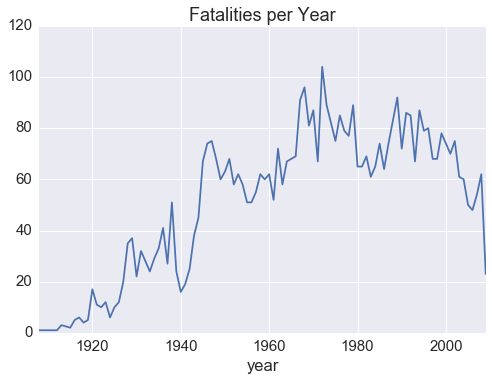

In [29]:
fatalities_df.groupby(df['year']).count()['fatalities'].plot(kind='line', legend=False, title="Fatalities per Year");

More fatalities happened during the 1970's.

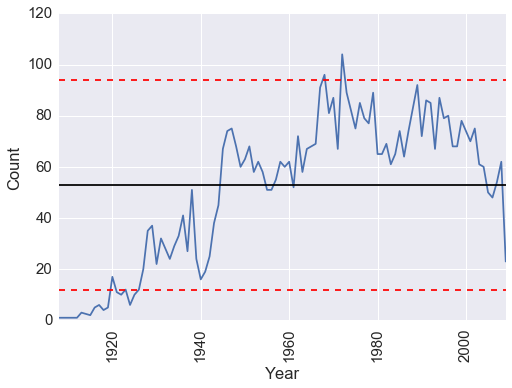

In [30]:
plot_accidents = fatalities_df.groupby(df['year']).count()['fatalities'].plot(rot=90)
plot_accidents.set(xlabel='Year', ylabel='Count')
plot_mean = fatalities_df.groupby(df['year']).count()['fatalities'].mean()
plot_std = fatalities_df.groupby(df['year']).count()['fatalities'].std()
plot_accidents.axhline(y=plot_mean, color='black')
plot_accidents.axhline(y=plot_mean+plot_std*1.5, color='red', ls='dashed')
plot_accidents.axhline(y=plot_mean-plot_std*1.5, color='red', ls='dashed')
plot_accidents;

The fatalities at the beggining of the XX century are outliers since there were few flights and most of them carried not many passengers aboard. Another outlier peaked during the 1970's.

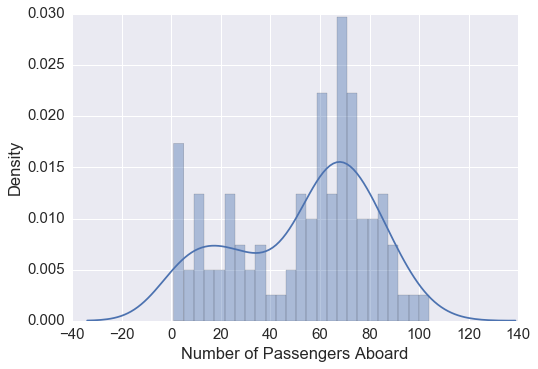

In [31]:
hist_chart = sns.distplot(df.groupby('year').count()['aboard'], bins=25)
hist_chart.set(xlabel="Number of Passengers Aboard", ylabel="Density");

It seems we have 2 distributions in above histogram.

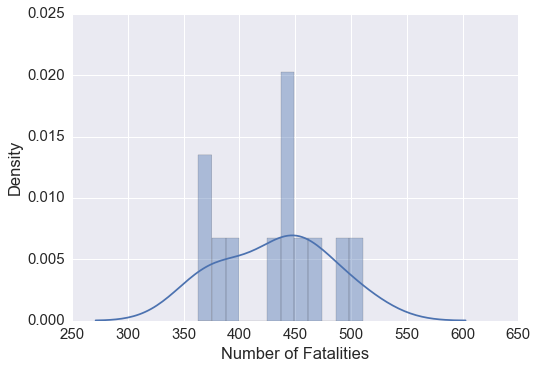

In [32]:
hist_chart = sns.distplot(df.groupby('month').count()['fatalities'], bins=12)
hist_chart.set(xlabel="Number of Fatalities", ylabel="Density");

In [33]:
fatalities_year_month = df.groupby(['year', 'month'])['fatalities'].count()

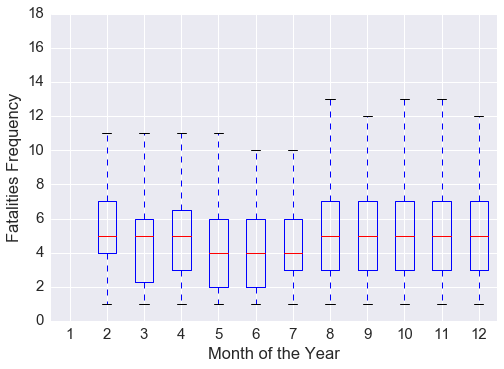

In [34]:
pylab.figure()
pylab.hold = True
boxes=[]
for i in range(0,12):
    x = fatalities_year_month.iloc[fatalities_year_month.index.get_level_values('month')==i]
    boxes.append(x)
pylab.boxplot(boxes,vert=1)
pylab.xlabel('Month of the Year')
pylab.ylabel('Fatalities Frequency')
pylab.boxplot
pylab.show()

From August to December we seem to have the worst casualties, including big dispersion in August, October and November. No data for January.

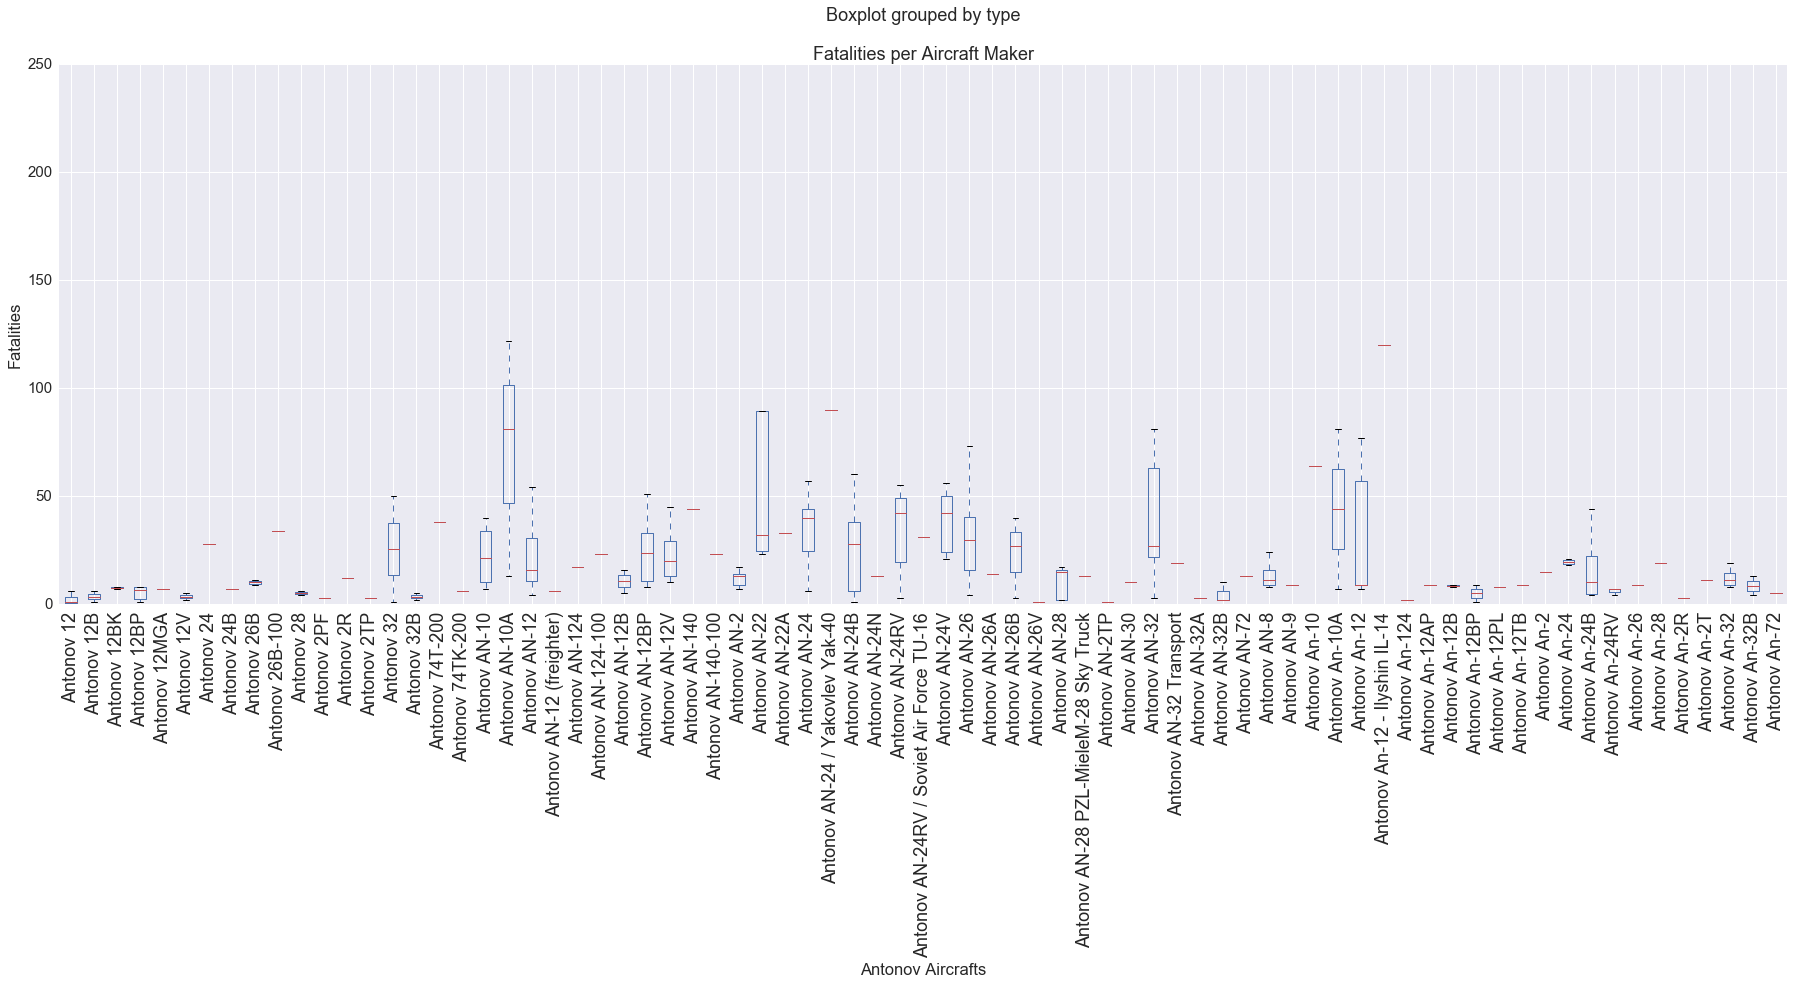

In [35]:
df[df['type'].str[:3] == ('Ant')].boxplot(column='fatalities', by='type', rot=90, figsize=(30, 10))
plt.xlabel('Antonov Aircrafts')
plt.ylabel('Fatalities')
plt.title('Fatalities per Aircraft Maker');

Most airplanes of type Antonov have fatalities, but the Antonov AN-10A tops as the one with nore fatalities.

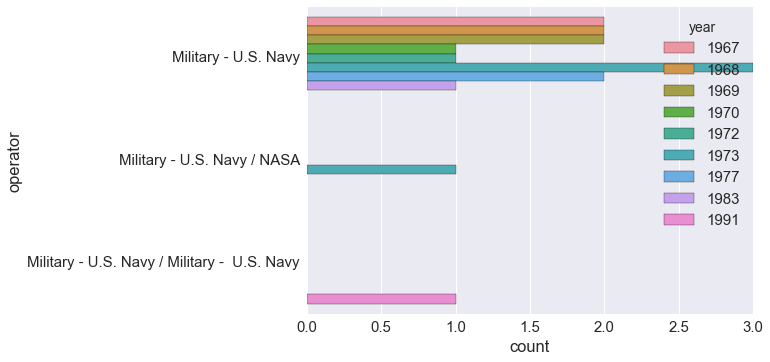

In [36]:
oper = df[(df['operator'].str[:20] == 'Military - U.S. Navy') & (df['year'] > 1966)]
sns.countplot(y='operator', data=oper, hue='year');

1973 was the worst year for the U.S. Navy (exploring after 1966).

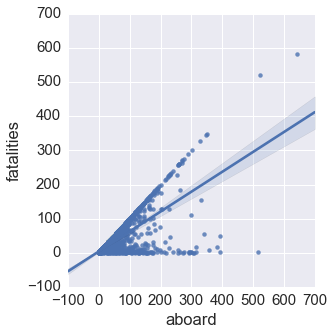

In [37]:
sns.lmplot(x='aboard', y='fatalities', data=df, fit_reg=True);

It seems there's a linear relationship between people aboard an airplane and casualties.

### Fitting a linear regression between fatalities and aboard.

In [38]:
y = df['fatalities']

In [39]:
X = df['aboard']

In [40]:
X = sm.add_constant(X)

In [41]:
model = sm.OLS(y, X)
results = model.fit()
results = results.summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     6954.
Date:                Tue, 11 Oct 2016   Prob (F-statistic):               0.00
Time:                        20:10:50   Log-Likelihood:                -23368.
No. Observations:                5192   AIC:                         4.674e+04
Df Residuals:                    5190   BIC:                         4.675e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0075      0.359     11.152      0.000       3.303       4.712
aboard         0.5834      0.007     83.390      0.000       0.570       0.597
==============================================================================
Omnibus:                     3296.863   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           236966.083
Skew:                          -2.265   Prob(JB):                         0.00
Kurtosis:                      35.785   Cond. No.                         61.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The percentage of the variation in y (fatalities) can be explained by the corresponding variation in X (passengers aboard) and the least-squares line is 57.3%, and the unexplained percentage of variation is 100% – 57.3% = 42.7%.
Every unit of increase in passengers aboard affects fatalities by 0.5834.

## EDA/Statistics

In [42]:
accidents_20_century = df[df['year'] < 2000]

In [43]:
accidents_21_century = df[df['year'] >= 2000]

In [44]:
accidents_20_century.groupby('type')['fatalities'].mean()

type
AAC-1 Toucan                             23.000000
AEGK                                      5.000000
AT L98 Carvair                            4.000000
ATR-72-212                               68.000000
Aermacchi MB-339PAN (3 aircraft)          3.000000
Aero Commander  520                       6.000000
Aero Commander 500-B                      2.000000
Aero Commander 500A                       7.000000
Aero Commander 560                        2.000000
Aero Commander 560-A                      5.000000
Aero Commander 560-F                      3.000000
Aero Commander 680                        3.000000
Aero Commander 680-E                      7.000000
Aero Commander 680E                       4.000000
Aero Commander 681                        2.000000
Aerospatiale 330G Puma                   10.000000
Aerospatiale 330J Puma                   13.000000
Aerospatiale 350B1                        3.000000
Aerospatiale 350D                         2.000000
Aerospatiale AS-350B      

In [45]:
accidents_20_century.groupby('type')['fatalities'].std()

type
AAC-1 Toucan                                   NaN
AEGK                                           NaN
AT L98 Carvair                                 NaN
ATR-72-212                                     NaN
Aermacchi MB-339PAN (3 aircraft)               NaN
Aero Commander  520                            NaN
Aero Commander 500-B                           NaN
Aero Commander 500A                            NaN
Aero Commander 560                             NaN
Aero Commander 560-A                           NaN
Aero Commander 560-F                           NaN
Aero Commander 680                        1.414214
Aero Commander 680-E                           NaN
Aero Commander 680E                       2.828427
Aero Commander 681                             NaN
Aerospatiale 330G Puma                         NaN
Aerospatiale 330J Puma                         NaN
Aerospatiale 350B1                             NaN
Aerospatiale 350D                              NaN
Aerospatiale AS-350B      

There are many NaN because most records by aircraft type have just one entry:

In [46]:
%%sql
SELECT *
FROM air_crashes
WHERE type = 'AAC-1 Toucan'

Done.


index,date,time,location,operator,flight#,route,type,registration,cn/in,aboard,fatalities,ground,summary
817,11/01/1946,None,"St Leger-la-Montagne, France",CTA LanguedoRoussillon,None,Paris - Toulouse - Casablanca,AAC-1 Toucan,F-BCAD,284,27.0,23.0,0.0,Crashed into mountains while en route. The pilot descended to lower altitiude to rid the plane of ice.


In [47]:
accidents_20_century.groupby('location')['fatalities'].mean()

location
1,200 miles off Dakar, AtlantiOcean              52.0
100 miles SW of Kuujjuaq, Quebec, Canada          2.0
25 nm off Agrigento, Italy                       26.0
300 nm NW of San Francisco, California            0.0
900 miles E of Honolulu, Hawaii, PacifiOcean     44.0
950 nm S of  Shemya, Alaska                       2.0
Abakan, Siberia, Russia                          23.0
Aberdeen, South Dakota                            6.0
Abidjan, Ivory Coast                             33.5
Abilene, Texas                                    2.0
Abuerio, Spain                                    1.0
Acapulco, Mexico                                  8.0
Adak, Alaska                                      1.0
Adana, Turkey                                    25.0
Adavale, Queensland, Australia                   12.0
Addis Ababa, Ethiopia                            22.0
Adelaide Hills, Australia                         1.0
Aden, Yemen                                       3.0
Adjuntas, Puerto Ri

In [48]:
accidents_20_century.groupby('location')['fatalities'].std()

location
1,200 miles off Dakar, AtlantiOcean                    NaN
100 miles SW of Kuujjuaq, Quebec, Canada               NaN
25 nm off Agrigento, Italy                             NaN
300 nm NW of San Francisco, California                 NaN
900 miles E of Honolulu, Hawaii, PacifiOcean           NaN
950 nm S of  Shemya, Alaska                            NaN
Abakan, Siberia, Russia                                NaN
Aberdeen, South Dakota                                 NaN
Abidjan, Ivory Coast                             23.334524
Abilene, Texas                                         NaN
Abuerio, Spain                                         NaN
Acapulco, Mexico                                       NaN
Adak, Alaska                                           NaN
Adana, Turkey                                          NaN
Adavale, Queensland, Australia                         NaN
Addis Ababa, Ethiopia                            29.698485
Adelaide Hills, Australia                      

In [49]:
accidents_21_century.groupby('type')['fatalities'].mean()

type
ATR 42-300                                    2.000000
ATR-42-300                                   46.000000
ATR-72-202                                   16.000000
Aerospatiale AS-350BA                         4.000000
Aerospatiale AS350 Eurocopter  helicoper      6.000000
Aerospatiale AS350BA                          7.000000
Aerospatiale AS350BA Rotocraft                4.000000
Aerospatiale AS355-F1                         7.000000
Aerospatiale BAe Concorde 101               109.000000
Aerospatiale SA365N-1 Dauphin II              4.000000
Aerospatiale SN-601 Corvette                  1.000000
Airbus A-300-605R                           260.000000
Airbus A-310-324                             32.000000
Airbus A-310-324ET                          128.000000
Airbus A-320-233                             95.000000
Airbus A-330-243                              0.000000
Airbus A-340                                  0.000000
Airbus A.330-301                              1.000000
Airbu

In [50]:
accidents_21_century.groupby('type')['fatalities'].std()

type
ATR 42-300                                         NaN
ATR-42-300                                         NaN
ATR-72-202                                         NaN
Aerospatiale AS-350BA                              NaN
Aerospatiale AS350 Eurocopter  helicoper           NaN
Aerospatiale AS350BA                               NaN
Aerospatiale AS350BA Rotocraft                     NaN
Aerospatiale AS355-F1                              NaN
Aerospatiale BAe Concorde 101                      NaN
Aerospatiale SA365N-1 Dauphin II                   NaN
Aerospatiale SN-601 Corvette                       NaN
Airbus A-300-605R                                  NaN
Airbus A-310-324                                   NaN
Airbus A-310-324ET                                 NaN
Airbus A-320-233                            130.107648
Airbus A-330-243                                   NaN
Airbus A-340                                       NaN
Airbus A.330-301                                   NaN
Airbu

In [51]:
accidents_21_century.groupby('location')['fatalities'].mean()

location
110 miles SW of Sochi, Russia                          78.0
200 miles NE of Derby, Australia                        4.0
Abuja, Nigeria                                          1.0
Abéché, Chad                                            5.0
Accra, Ghana                                            7.0
Adar Yeil, Sudan                                       14.0
Alamosa, Colorado                                       3.0
Alma, Wisconsin                                         1.0
Alto da Boa Vista, Brazil                               2.0
Amsterdam, Netherlands                                  9.0
Anchor Point, Alaska                                    3.0
Anchorage, Alaska                                       3.0
Anjouan, Comoros Islands                                1.0
Arlington, Virginia.                                   64.0
Aru, DemocratiRepubliCogo                               2.0
Ashbaubenon, Wisconsin                                  1.0
AtlantiOcean, 570 miles northea

In [52]:
accidents_21_century.groupby('location')['fatalities'].std()

location
110 miles SW of Sochi, Russia                        NaN
200 miles NE of Derby, Australia                     NaN
Abuja, Nigeria                                       NaN
Abéché, Chad                                         NaN
Accra, Ghana                                         NaN
Adar Yeil, Sudan                                     NaN
Alamosa, Colorado                                    NaN
Alma, Wisconsin                                      NaN
Alto da Boa Vista, Brazil                            NaN
Amsterdam, Netherlands                               NaN
Anchor Point, Alaska                                 NaN
Anchorage, Alaska                                    NaN
Anjouan, Comoros Islands                             NaN
Arlington, Virginia.                                 NaN
Aru, DemocratiRepubliCogo                            NaN
Ashbaubenon, Wisconsin                               NaN
AtlantiOcean, 570 miles northeast of Natal, Brazil   NaN
Aurora, Illinois      

To reiterate what I mentioned before, we get NaN since most locations, when grouped, have only 1 record:

In [53]:
%%sql
SELECT *
FROM air_crashes
WHERE location = '110 miles SW of Sochi, Russia'

Done.


index,date,time,location,operator,flight#,route,type,registration,cn/in,aboard,fatalities,ground,summary
4809,10/04/2001,13:44,"110 miles SW of Sochi, Russia",Sibir Airlines,1812,"Tel Aviv - Novosibirsk, Russia",Tupolev Tu-154M,RA-85693,90A-866,78.0,78.0,0.0,"The aircraft exploded in mid-air at 36,000 ft. while en route over the Black Sea. The plane then nose-dived crashing into the water. The airliner was brought down accidentally by a Ukrainian surface-to-air missile, fired during military exercises."


## Statistics/Random Sampling

In [54]:
sample_100 = df.sample(100)

In [55]:
sample_100.fatalities.describe()

count    100.000000
mean      19.920000
std       30.204247
min        1.000000
25%        3.750000
50%        9.000000
75%       23.250000
max      223.000000
Name: fatalities, dtype: float64

In [56]:
df.fatalities.describe()

count    5192.000000
mean       20.174307
std        33.345674
min         0.000000
25%         3.000000
50%         9.000000
75%        23.000000
max       583.000000
Name: fatalities, dtype: float64

Our small sample size has descriptive statistics less higher that the total sample size.

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


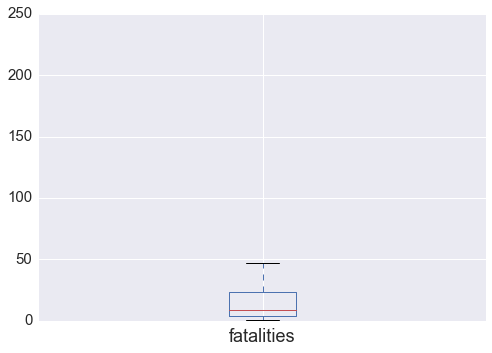

In [57]:
sample_100.boxplot(column='fatalities');

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


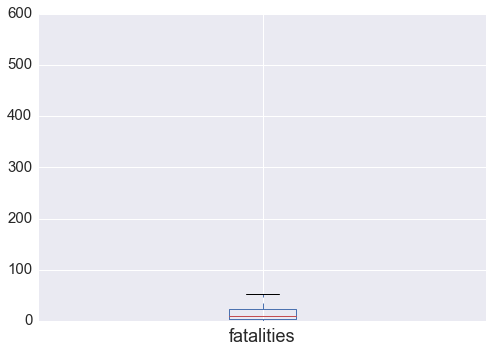

In [58]:
df.boxplot(column='fatalities');

In [59]:
sample_100.aboard.describe()

count    100.000000
mean      22.460000
std       30.098297
min        2.000000
25%        5.000000
50%       12.000000
75%       27.500000
max      223.000000
Name: aboard, dtype: float64

In [60]:
df.aboard.describe()

count    5192.000000
mean       27.709553
std        43.249537
min         0.000000
25%         5.000000
50%        13.000000
75%        30.000000
max       644.000000
Name: aboard, dtype: float64

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


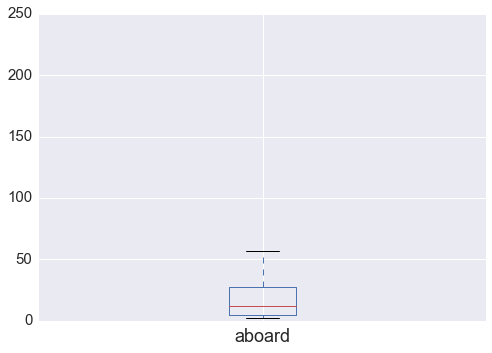

In [61]:
sample_100.boxplot(column='aboard');

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


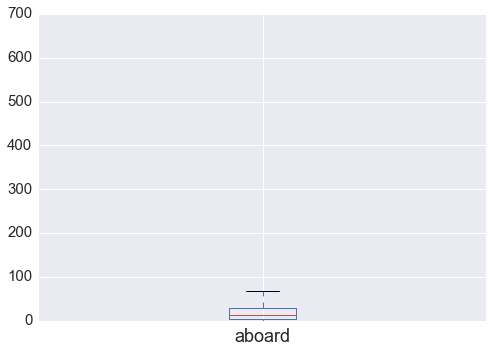

In [62]:
df.boxplot(column='aboard');

Defense variable is very similar for the sample and the population.

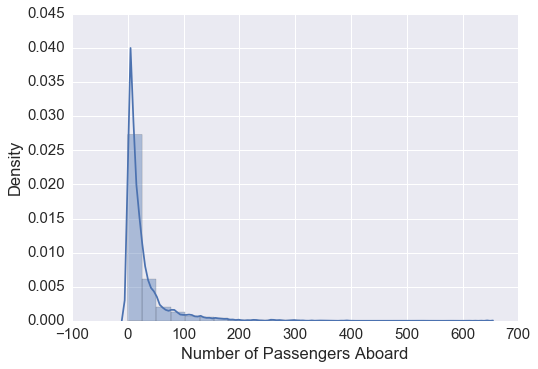

In [63]:
hist_chart_aboard = sns.distplot(df['aboard'], bins=25)
hist_chart_aboard.set(xlabel="Number of Passengers Aboard", ylabel="Density");

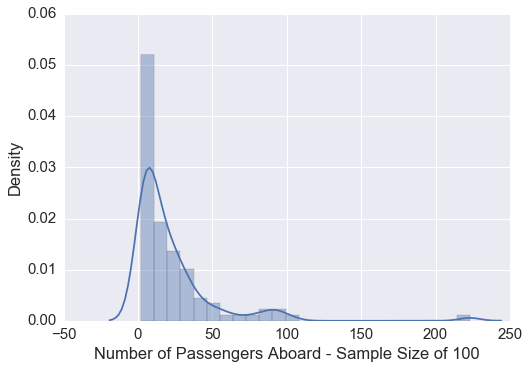

In [64]:
hist_chart_aboard_sample = sns.distplot(sample_100['aboard'], bins=25)
hist_chart_aboard_sample.set(xlabel="Number of Passengers Aboard - Sample Size of 100", ylabel="Density");

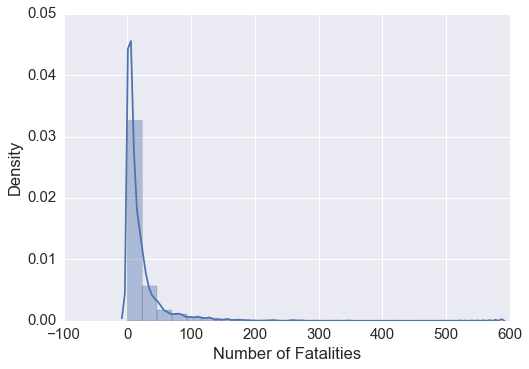

In [65]:
hist_chart_fatalities = sns.distplot(df['fatalities'], bins=25)
hist_chart_fatalities.set(xlabel="Number of Fatalities", ylabel="Density");

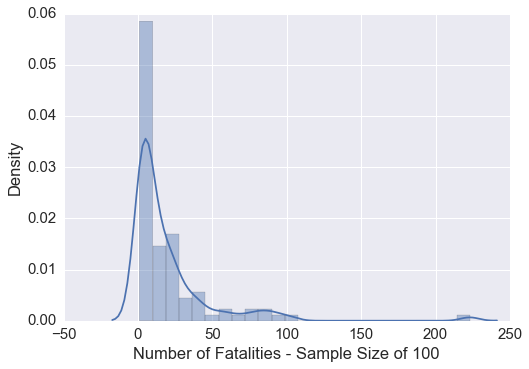

In [66]:
hist_chart_fatalities_sample = sns.distplot(sample_100['fatalities'], bins=25)
hist_chart_fatalities_sample.set(xlabel="Number of Fatalities - Sample Size of 100", ylabel="Density");

## Probability

### Given that you have an accident (fatality), what is the probability that you flew on an airplane of type Antonov?
$P(antonov | fatality) = P(antonov \cap fatality)/P(fatality)$

In [67]:
%%sql
SELECT COUNT(*) AS "Count of Antonovs"
FROM air_crashes
WHERE type LIKE 'Antonov%'

Done.


Count of Antonovs
247


In [68]:
%%sql
SELECT COUNT(*) AS "Count of Non-Antonovs"
FROM air_crashes
WHERE type NOT LIKE 'Antonov%'

Done.


Count of Non-Antonovs
4994


In [69]:
%%sql
SELECT COUNT(*) AS "Count of Antonovs Fatalities"
FROM air_crashes
WHERE type LIKE 'Antonov%' AND fatalities > 0

Done.


Count of Antonovs Fatalities
246


In [70]:
%%sql
SELECT COUNT(*) AS "Count of Items"
FROM air_crashes

Done.


Count of Items
5268


In [71]:
%%sql
SELECT COUNT(*) AS "Count of Other Airplanes Fatalities"
FROM air_crashes
WHERE type NOT LIKE 'Antonov%' AND fatalities > 0

Done.


Count of Other Airplanes Fatalities
4927


<img src="images/air_crashes_ant.jpg">

TOTAL = 247/5268 * 246/247 + 4994/5268 * 4927/4994

PROBABILITY = 247/5268 * 246/247/TOTAL

In [72]:
total = 247/5268 * 246/247 + 4994/5268 * 4927/4994
probability = 247/5268 * 246/247/total
print("Probability:", probability*100, "%")

Probability: 4.7554610477479216 %


### If you take 10 airplanes of type Antonov, what is the probability of surviving all 10 flights?

P(fatality $\cap$ antonov) = 246/247 = 0.995

So, the probability of not having a fatality flying and Antonov is: 1 - 0.995 = 0.004

For survive in 10 consecutive flights, the probability is:

(0.004)$^{10}$ $\simeq$ 0

## Probability Distribution

Fatalities is a discrete distribution, and theoretically, it's an event that should follow a Poisson distribution.

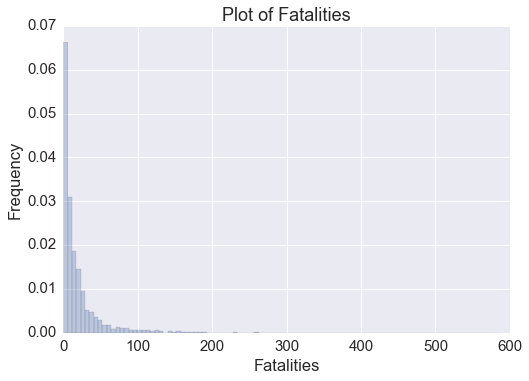

In [73]:
df.hist(column='fatalities', bins=100, alpha=.3, normed=True)
title('Plot of Fatalities')
ylabel('Frequency');
xlabel('Fatalities');

We can have an estimate of the Poisson $\lambda$, using MOM, the 1st moment.

In [74]:
df.fatalities.mean()

20.174306625577813

In [75]:
x = linspace(df.fatalities.min(), df.fatalities.max(), 100)
pois = stats.poisson(df.fatalities.mean())
plot_pois = pois.pmf(x)

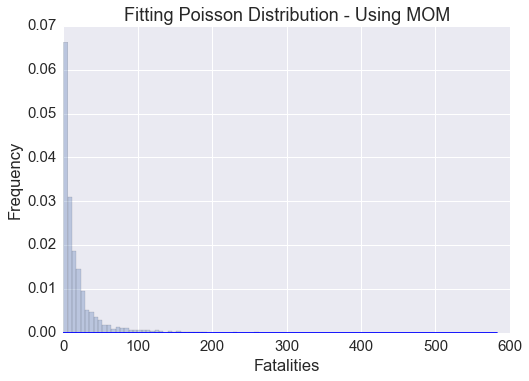

In [76]:
df.hist(column='fatalities', bins=100, alpha=.3, normed=True)
plot(x, plot_pois, color='blue')
title('Fitting Poisson Distribution - Using MOM')
ylabel('Frequency')
xlabel('Fatalities');

Even though Poisson is in theory, based on the type of event, a good fit, it is not.

Using MLE to estimate $\lambda$:

$P(x_i) = \frac{e^{-\lambda} \lambda^{x_i}}{x_i !}$

$L(x|\lambda) = \sum_{i=1}^{n}P(x_i)$

We take the logarithm of above to make easier the derivative step:

$l(x) = log(L(x|\lambda)) = log(\prod_{i=1}^{n}P(x_i)) = log(\prod_{i=1}^{n}\frac{e^{-\lambda} \lambda^{x_i}}{x_i !} ) = -n \lambda + log(\lambda)\sum_{i=1}^{n} x_i - log(\prod_{i=1}^{n} x_i)$

Taking the derivative to maximize:

$\frac{dP}{d\lambda} = d(-n \lambda + log(\lambda)\sum_{i=1}^{n} x_i - log(\prod_{i=1}^{n} x_i)) = -n + \frac{\sum_{i=1}^{n} x_i}{\lambda}$

If $\frac{dP}{d\lambda} = 0$, then $\lambda = \frac{\sum_{i=1}^{n} x_i}{n}$, which provides the same result as the MOM 1st moment.

Using a manual input for $\lambda$:

In [77]:
x = linspace(df.fatalities.min(), df.fatalities.max(), 100)
pois = stats.poisson(1/df.fatalities.mean())
plot_pois = pois.pmf(x)

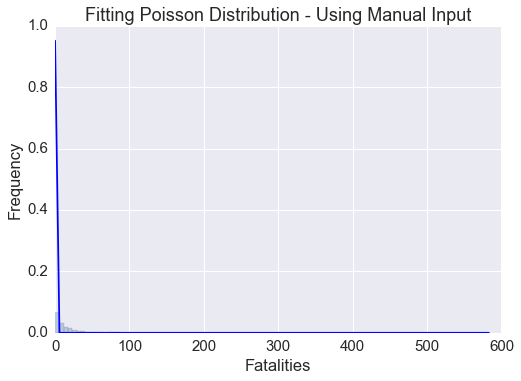

In [78]:
df.hist(column='fatalities', bins=100, alpha=.3, normed=True)
plot(x, plot_pois, color='blue')
title('Fitting Poisson Distribution - Using Manual Input')
ylabel('Frequency')
xlabel('Fatalities');

Not a good fit.

In [79]:
import fit
optimal_lambda = fit.fit_poisson(df['fatalities'])
optimal_poisson = stats.poisson(optimal_lambda)
optimal_poisson_y = optimal_poisson.pmf(x)
optimal_lambda

200.27053003903018

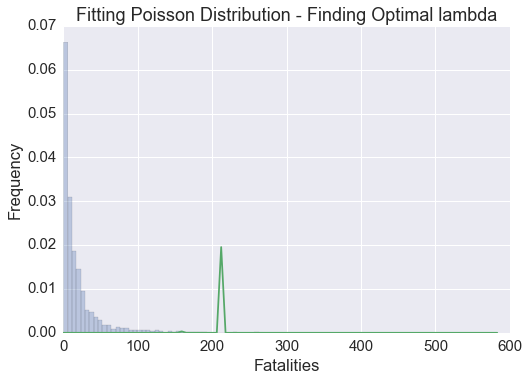

In [80]:
df['fatalities'].hist(bins=100, alpha=.3, normed=True)
plt.plot(x, optimal_poisson_y)
title('Fitting Poisson Distribution - Finding Optimal lambda')
ylabel('Frequency')
xlabel('Fatalities');

Uing the fit.py script to try to find the best poisson, it's not a good fit either, in fact, very far off.

In [81]:
x = linspace(df.fatalities.min(), df.fatalities.max(), 100)
geom = stats.geom(1/df.fatalities.mean())
plot_geom = geom.pmf(x)

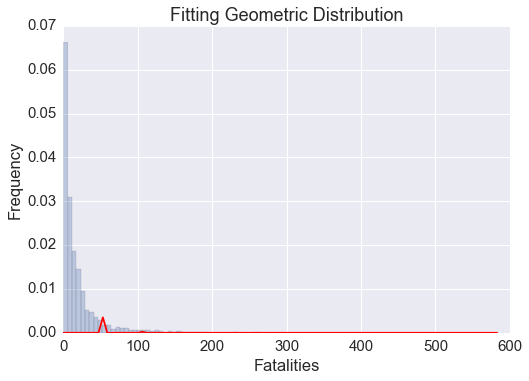

In [82]:
df.hist(column='fatalities', bins=100, alpha=.3, normed=True)
plot(x, plot_geom, color='red')
title('Fitting Geometric Distribution')
ylabel('Frequency')
xlabel('Fatalities');

Above I have tried a geometric distribution, but again it seems not a good fit either.

In [83]:
x = linspace(df.fatalities.min(), df.fatalities.max(), 100)
binom = stats.binom(1000, 0.09)
plot_binom = binom.pmf(x)

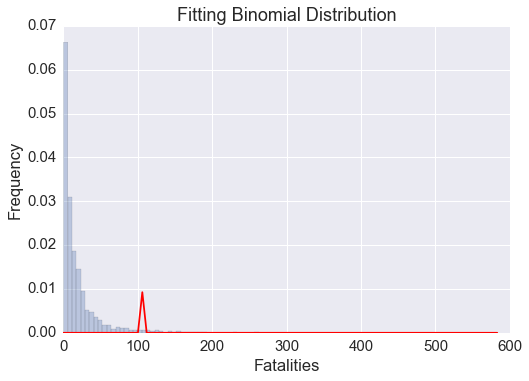

In [84]:
df.hist(column='fatalities', bins=100, alpha=.3, normed=True)
plot(x, plot_binom, color='red')
title('Fitting Binomial Distribution')
ylabel('Frequency')
xlabel('Fatalities');

Above I have tried a binomial distribution, but doesn't fit very well either.

In [85]:
x = linspace(df.fatalities.min(), df.fatalities.max(), 100)
neg_binom = stats.nbinom(1000, 0.95)
plot_nbinom = neg_binom.pmf(x)

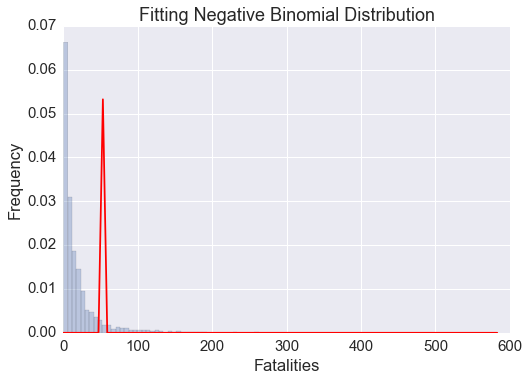

In [86]:
df.hist(column='fatalities', bins=100, alpha=.3, normed=True)
plot(x, plot_nbinom, color='red')
title('Fitting Negative Binomial Distribution')
ylabel('Frequency')
xlabel('Fatalities');

Above I have tried a negative binomial distribution, but doesn't fit very well either.

Now, let's try a continuous distribution, the exponential distribution to answer the question 'how much time between fatalities' since fatalities should follow a poisson distribution. We will have time variable in the x-axis.

To estimate $\lambda$, we calculate the inverse of: total fatalities/year span.

In [87]:
number_of_fatalities = df.fatalities.count()
number_of_fatalities

5192

In [88]:
year_span = df.year.max() - df.year.min()
year_span

101

In [89]:
lambda_exp = number_of_fatalities/year_span
lambda_exp

51.405940594059409

51.41 fatalities/year

Plotting the exponential distribution:

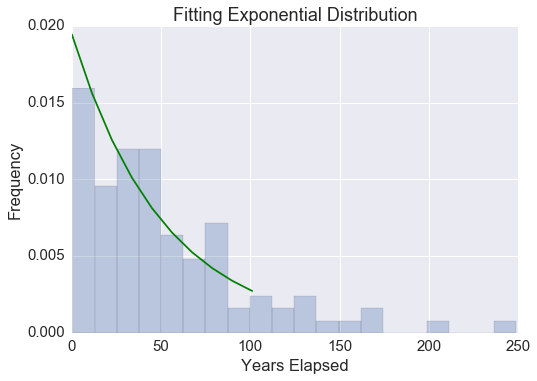

In [90]:
x = linspace(df.year.min() - df.year.min(), df.year.max() - df.year.min(), 10)
exp = stats.expon(scale=lambda_exp)
plot_exp = exp.pdf(x)
hist(exp.rvs(year_span),bins=20,alpha=.3,normed=True)
plot(x, plot_exp, color='green')
title('Fitting Exponential Distribution')
ylabel('Frequency')
xlabel('Years Elapsed');